<a href="https://colab.research.google.com/github/shubhs29/PRODIGY_DS_04/blob/main/TwitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Analyze and visualize sentiment patterns in social media data to understand public opinion and attitudes towards specific topics or brands.

In [1]:
!pip install tensorflow

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import warnings
warnings.filterwarnings('ignore')
custom_palette = ['#F3E0D1', '#E0B19D', '#B8BC94', '#BE6674', '#741C28']


In [5]:
df_train=pd.read_csv('/content/twitter_training.csv')
df_test=pd.read_csv('/content/twitter_validation.csv')

Exploring Data

In [6]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
df_test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15836 entries, 0 to 15835
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   15836 non-null  int64 
 1   Borderlands                                            15836 non-null  object
 2   Positive                                               15836 non-null  object
 3   im getting on borderlands and i will murder you all ,  15675 non-null  object
dtypes: int64(1), object(3)
memory usage: 495.0+ KB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                              --------------  ----- 
 0   3364                                                                                                                                                                                                                                                999 non-null    int64 
 1   Facebook                                                                   

The datasets contain four columns each, although column names are incorrectly set. It appears that:

1. The first column is an identifier.
2. The second column represents a brand or topic (e.g. "Borderlands," "Facebook," "Amazon").
3. The third column indicates the sentiment label, such as "Positive," "Negative," or "Neutral."
4. The fourth column contains the tweet text.

In [10]:
# Renaming columns for better readability
df_train.columns = ['ID', 'Topic', 'Sentiment', 'Text']
df_test.columns = ['ID', 'Topic', 'Sentiment', 'Text']

In [11]:
df_train.head()

,ID,Topic,Sentiment,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [12]:
df_test.head()

,ID,Topic,Sentiment,Text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [13]:
# Checking for any null values in important columns after renaming
train_nulls=df_train.isnull().sum()/df_train.shape[0]*100
test_nulls=df_test.isnull().sum()/df_test.shape[0]*100

In [14]:
train_nulls, test_nulls

(ID           0.000000
 Topic        0.000000
 Sentiment    0.000000
 Text         1.016671
 dtype: float64,
 ID           0.0
 Topic        0.0
 Sentiment    0.0
 Text         0.0
 dtype: float64)

Cleaning Data

In [15]:
#Dropping rows with missing 'Text' values in the training data
df_train.dropna(subset=['Text'], inplace=True)


In [16]:
#Checking Duplicate Values
df_train.duplicated().sum()

525

In [17]:
df_test.duplicated().sum()

0

In [18]:
df_train.drop_duplicates(inplace=True)

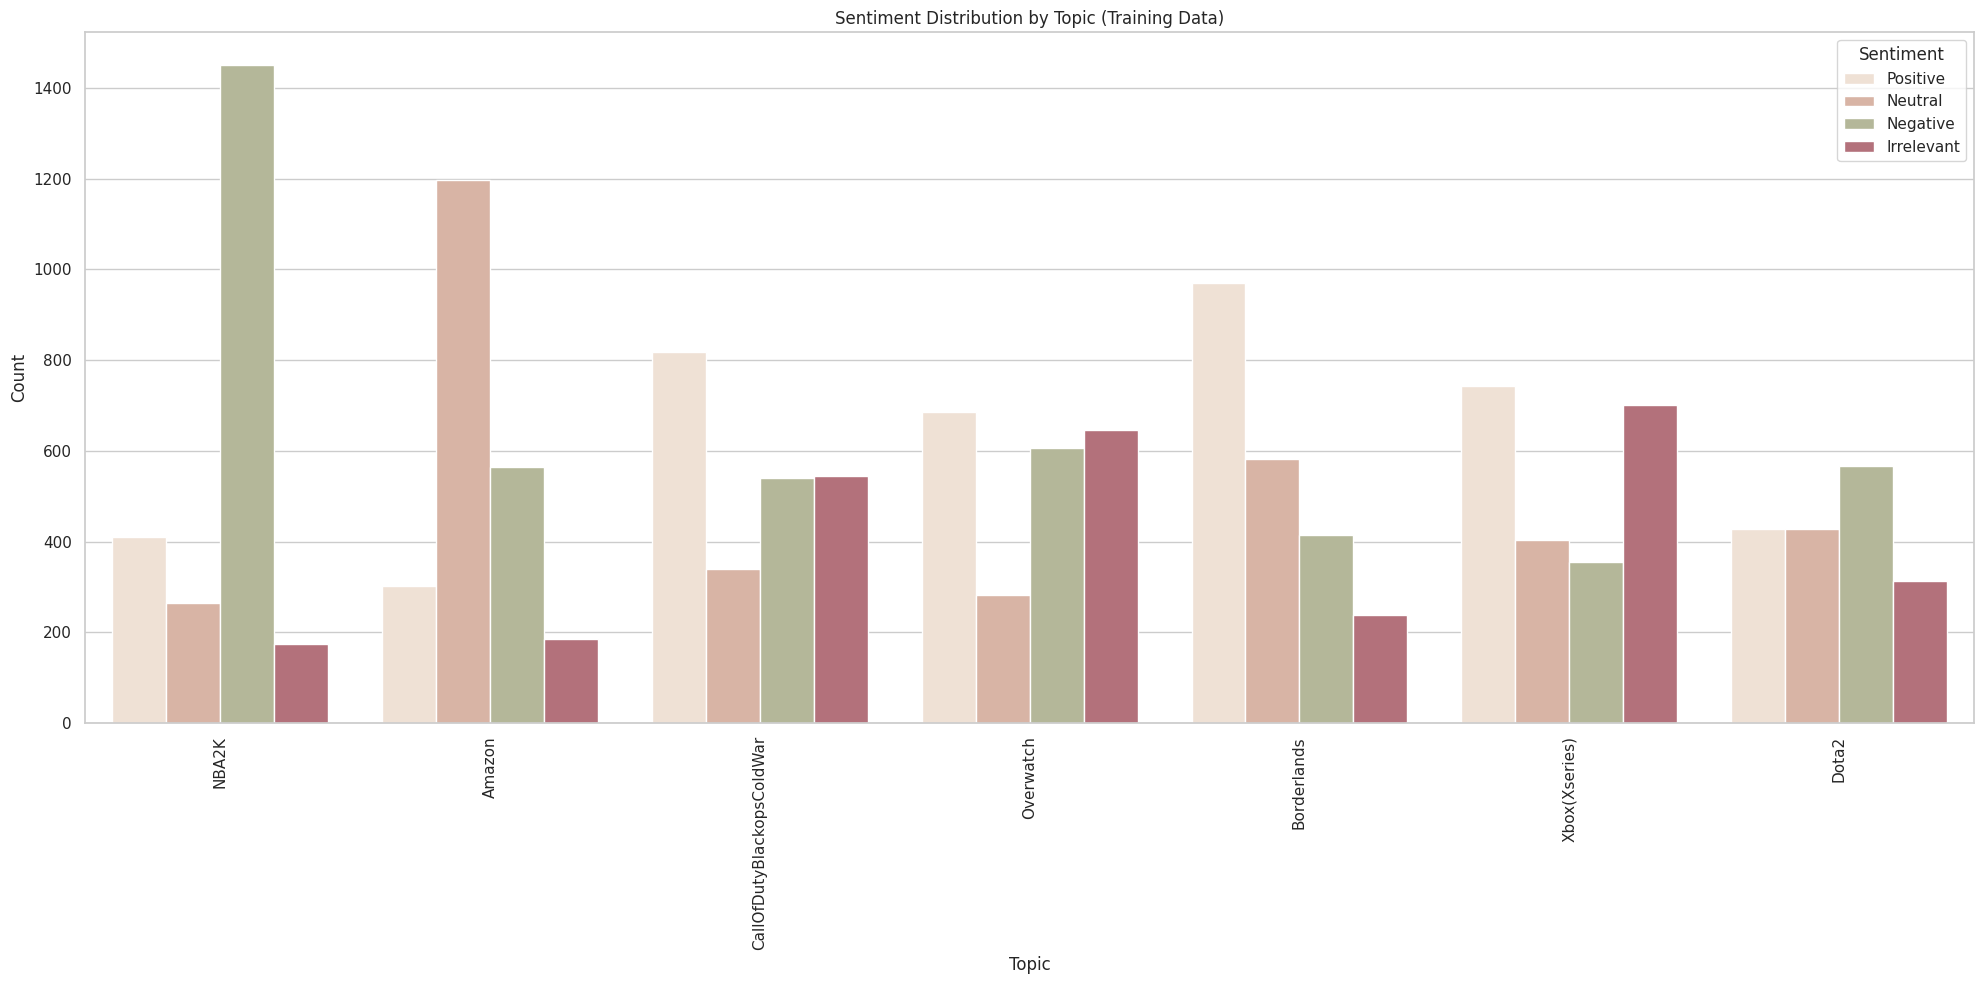

In [19]:
# Setting up the plotting style
sns.set(style="whitegrid")

# Plotting sentiment distribution by topic in the training data
plt.figure(figsize=(20, 10))
sns.countplot(data=df_train, x='Topic', hue='Sentiment', order=df_train['Topic'].value_counts().index, palette=custom_palette)
plt.title('Sentiment Distribution by Topic (Training Data)')
plt.xlabel('Topic',fontsize=12)
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

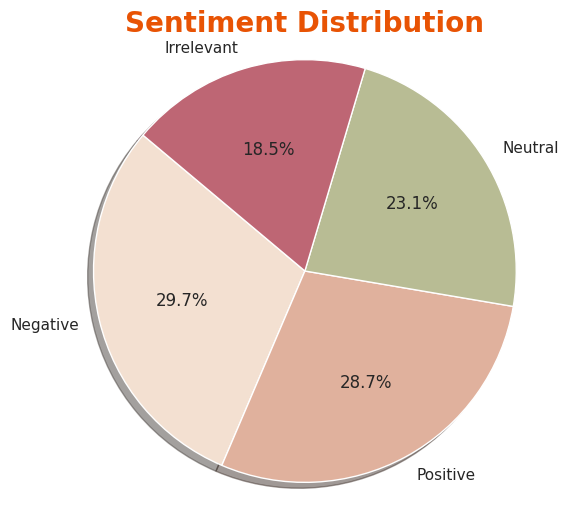

In [20]:
#piechart for the sentiment distribution
sentiment_counts = df_train['Sentiment'].value_counts()
# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.title('Sentiment Distribution', weight="bold", fontsize=20, color='#e85304')

plt.pie(sentiment_counts,
        labels=sentiment_counts.index,
        startangle=140,
        autopct='%1.1f%%',
        colors=custom_palette,
        shadow=True)

plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()


Preprocessing the Data

In [21]:
df_train.drop(columns=['ID', 'Topic'], inplace=True)
df_test.drop(columns=['ID', 'Topic'], inplace=True)


In [22]:
df_train


,Sentiment,Text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
15827,Negative,wtf
15831,Negative,She wtf
15833,Irrelevant,ICYMI: @BLASTDota finds sponsor in @KITKAT. . ...
15834,Irrelevant,ICYMI: @ BLASTDota finds sponsor in @ KITKAT. ...


In [23]:
df_test


,Sentiment,Text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [24]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove special characters, numbers, and punctuations
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    return tweet

In [25]:
# Clean the training data
df_train['Text'] = df_train['Text'].apply(clean_tweet)

# Clean the test data
df_test['Text'] = df_test['Text'].apply(clean_tweet)

In [26]:
df_train.head()

,Sentiment,Text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [27]:
df_train['Text'] = df_train['Text'].str.lower()
df_test['Text'] = df_test['Text'].str.lower()

In [28]:
# Drop rows where 'OriginalTweet' is empty
df_train = df_train.dropna(subset=['Text'])
df_test = df_test.dropna(subset=['Text'])

# Alternatively, if there are rows with just whitespace, use this to remove them as well:
df_train = df_train[df_train['Text'].str.strip() != '']
df_test = df_test[df_test['Text'].str.strip() != '']

# Display the updated dataframe
df_train.head()

,Sentiment,Text
0,Positive,i am coming to the borders and i will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [29]:
df_train.duplicated().sum()

882

In [30]:
df_train = df_train.drop_duplicates(subset=['Text'])

In [31]:
df_train.shape

(14104, 2)

In [32]:
# Separate features and labels for training data
train_texts = df_train['Text'].values
train_labels = df_train['Sentiment'].values

# Separate features and labels for test data
test_texts = df_test['Text'].values
test_labels = df_test['Sentiment'].values

In [33]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [34]:
# Initialize the tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()  # You can adjust the number of words

# Fit the tokenizer on the training texts
tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)

In [35]:
# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [36]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 166


In [37]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [38]:
print("train_padded shape:", train_padded.shape)  # Should be (num_samples, maxlen)
print("test_padded shape:", test_padded.shape)

train_padded shape: (14104, 166)
test_padded shape: (999, 166)


In [39]:
# Embedding Input Size
input_size = np.max(train_padded) + 1
input_size

11062

In [40]:
# Define the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(56,)))

# Add a bidirectional LSTM layer with 128 units
model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.1), return_sequences=True, recurrent_regularizer=l2(0.1))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add another LSTM layer
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
# Add batch normalization layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 5 units for 5 labels and softmax activation
model.add(Dense(5, activation='softmax'))

In [41]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 56, 100)             │       1,106,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 56, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,515,165 (5.78 MB)

 Trainable params: 1,514,397 (5.78 MB)

 Non-trainable params: 768 (3.00 KB)

In [42]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [43]:
print(train_labels_encoded.shape)
print(test_labels_encoded.shape)
print(type(train_labels_encoded[0]))  # Should be integer, e.g., np.int32


(14104,)
(999,)
<class 'numpy.int64'>


In [44]:
train_labels_encoded = train_labels_encoded.astype(np.int32)
test_labels_encoded = test_labels_encoded.astype(np.int32)

In [85]:
history = model.fit(
    train_padded,
    train_labels_encoded ,
    validation_data=(test_padded,test_labels_encoded),
    epochs=10
)

Epoch 1/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.4098 - loss: 8.5089

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/embedding_1/GatherV2 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-85-5bee1136a6af>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 343, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 209, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 140, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4875, in take

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1951, in take

indices[26,26] = 29394 is not in [0, 29385)
	 [[{{node sequential_1/embedding_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_38947]

In [45]:
test_loss, test_accuracy = model.evaluate(test_padded , test_labels_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/embedding_1/GatherV2 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-45-867ee22d0642>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 429, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 209, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 140, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4875, in take

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1951, in take

indices[29,10] = 11115 is not in [0, 11062)
	 [[{{node sequential_1/embedding_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_2137]

NameError: name 'history' is not defined

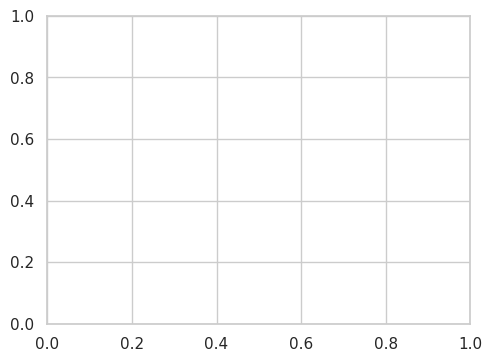

In [46]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()